In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def analyze_and_plot_metrics(base_path):
    base_path = Path(base_path)
    val_files = list(base_path.rglob("val_metrics.csv"))
    train_files = list(base_path.rglob("train_metrics.csv"))

    if not val_files or not train_files:
        print("No metric files found.")
        return

    all_results = []

    print(f"Found {len(val_files)} validation metric files.")
    
    for val_file in val_files:
        outdir = val_file.parent
        try:
            val_df = pd.read_csv(val_file)
            train_df = pd.read_csv(outdir / "train_metrics.csv")
        except Exception as e:
            print(f"Skipping {val_file} due to error: {e}")
            continue

        val_df['epoch'] = range(len(val_df))
        train_df['epoch'] = range(len(train_df))

        if 'loss' not in val_df.columns:
            print(f"Skipping {val_file} — missing required metrics.")
            continue

        min_loss = val_df['loss'].min()
        all_results.append((min_loss, outdir, val_df, train_df))

    if not all_results:
        print("No valid metric files with 'loss' found.")
        return

    # Find the experiment with the lowest validation loss
    best_run = min(all_results, key=lambda x: x[0])
    min_val_loss, best_dir, val_df, train_df = best_run

    print(f"Best validation loss: {min_val_loss:.4f} in {best_dir}")

    # Plot metrics
    metrics_to_plot = ['loss', 'regret', 'deterministic_bpr', 'nll']

    for metric in metrics_to_plot:
        if metric in val_df.columns and metric in train_df.columns:
            plt.figure(figsize=(10, 5))
            plt.plot(train_df['epoch'], train_df[metric], label=f"Train {metric}")
            plt.plot(val_df['epoch'], val_df[metric], label=f"Val {metric}")
            plt.title(f"{metric} over epochs\n{best_dir}")
            plt.xlabel("Epoch")
            plt.ylabel(metric)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Metric '{metric}' not found in both train and val for {best_dir}.")

def analyze_with_rolling_avg(base_path, window=5):
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt

    base_path = Path(base_path)
    val_files = list(base_path.rglob("val_metrics.csv"))

    all_results = []

    for val_file in val_files:
        try:
            val_df = pd.read_csv(val_file)
        except Exception as e:
            print(f"Skipping {val_file} due to read error: {e}")
            continue

        if 'loss' not in val_df.columns:
            continue

        val_df['epoch'] = range(len(val_df))
        val_df['loss_roll'] = val_df['loss'].rolling(window=window, min_periods=1).mean()
        min_roll = val_df['loss_roll'].min()

        all_results.append((min_roll, val_file.parent, val_df))

    if not all_results:
        print("No valid results found.")
        return

    # Select best model based on rolling average
    best_run = min(all_results, key=lambda x: x[0])
    min_roll_loss, best_dir, val_df = best_run

    print(f"Best rolling val_loss ({window}-epoch window): {min_roll_loss:.4f} in {best_dir}")

    # Plot loss + rolling average
    plt.figure(figsize=(10, 5))
    plt.plot(val_df['epoch'], val_df['loss'], label='Val Loss')
    plt.plot(val_df['epoch'], val_df['loss_roll'], label=f'{window}-Epoch Rolling Avg')
     # Plot metrics
    metrics_to_plot = ['loss', 'regret', 'deterministic_bpr', 'nll']

    for metric in metrics_to_plot:
        if metric in val_df.columns:
            plt.figure(figsize=(10, 5))
            plt.plot(val_df['epoch'], val_df[metric], label=f"Val {metric}")
            plt.title(f"{metric} over epochs\n{best_dir}")
            plt.xlabel("Epoch")
            plt.ylabel(metric)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Metric '{metric}' not found in both train and val for {best_dir}.")


import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
from collections import defaultdict

def extract_dataset_and_method(path):
    """
    Extracts dataset and method_name from path parts.
    Assumes pattern like: MA_pg_step1e-2 or cook_spo+_step1e-2_noise1e-1
    """
    name = path.name
    match = re.match(r"(MA|cook|asurv)_([^_]+)", name)
    if match:
        dataset, method = match.groups()
        return dataset, method
    return None, None

def analyze_and_plot_metrics_grouped(base_path):
    base_path = Path(base_path)
    val_files = list(base_path.rglob("val_metrics.csv"))
    train_files = list(base_path.rglob("train_metrics.csv"))

    print(f"Found {len(val_files)} validation files.")

    grouped_runs = defaultdict(list)

    for val_file in val_files:
        outdir = val_file.parent
        try:
            val_df = pd.read_csv(val_file)
            train_df = pd.read_csv(outdir / "train_metrics.csv")
        except Exception as e:
            print(f"Skipping {val_file} due to error: {e}")
            continue

        dataset, method = extract_dataset_and_method(outdir)
        if not dataset or not method or 'loss' not in val_df.columns:
            continue

        val_df['epoch'] = range(len(val_df))
        train_df['epoch'] = range(len(train_df))
        min_loss = val_df['loss'].min()

        grouped_runs[(dataset, method)].append((min_loss, outdir, val_df, train_df))

    if not grouped_runs:
        print("No valid metric files with 'loss' found.")
        return

    for (dataset, method), runs in grouped_runs.items():
        best_run = min(runs, key=lambda x: x[0])
        min_val_loss, outdir, val_df, train_df = best_run

        print(f"[{dataset}, {method}] → Best val_loss: {min_val_loss:.4f} at {outdir}")

        metrics_to_plot = ['loss', 'regret', 'deterministic_bpr', 'nll']
        for metric in metrics_to_plot:
            if metric in val_df.columns and metric in train_df.columns:
                plt.figure(figsize=(10, 5))
                plt.plot(train_df['epoch'], train_df[metric], label=f"Train {metric}")
                plt.plot(val_df['epoch'], val_df[metric], label=f"Val {metric}")
                plt.title(f"{metric} over epochs — {dataset}, {method}\n{outdir.name}")
                plt.xlabel("Epoch")
                plt.ylabel(metric)
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Metric '{metric}' not found in both train and val for {outdir}.")


import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
from collections import defaultdict

def extract_dataset_and_method(path):
    """
    Extracts dataset and method_name from path parts.
    Assumes pattern like: MA_pg_step1e-2 or cook_spo+_step1e-2_noise1e-1
    """
    name = path.name
    match = re.match(r"(MA|cook|asurv)_([^_]+)", name)
    if match:
        dataset, method = match.groups()
        return dataset, method
    return None, None

def analyze_and_plot_by_final_bpr(base_path):
    base_path = Path(base_path)
    val_files = list(base_path.rglob("val_metrics.csv"))

    print(f"Found {len(val_files)} validation files.")

    grouped_runs = defaultdict(list)

    for val_file in val_files:
        outdir = val_file.parent
        train_file = outdir / "train_metrics.csv"

        try:
            val_df = pd.read_csv(val_file)
            train_df = pd.read_csv(train_file)
        except Exception as e:
            print(f"Skipping {val_file} due to error: {e}")
            continue

        dataset, method = extract_dataset_and_method(outdir)
        if not dataset or not method or 'deterministic_bpr' not in val_df.columns:
            continue

        val_df['epoch'] = range(len(val_df))
        train_df['epoch'] = range(len(train_df))
        final_bpr = val_df['deterministic_bpr'].iloc[-1]

        grouped_runs[(dataset, method)].append((final_bpr, outdir, val_df, train_df))

    if not grouped_runs:
        print("No valid runs with 'deterministic_bpr' found.")
        return

    for (dataset, method), runs in grouped_runs.items():
        # Select run with highest final deterministic_bpr
        best_run = max(runs, key=lambda x: x[0])
        final_bpr, outdir, val_df, train_df = best_run

        print(f"[{dataset}, {method}] → Best final BPR: {final_bpr:.4f} at {outdir}")

        metrics_to_plot = ['loss', 'regret', 'deterministic_bpr', 'nll']
        for metric in metrics_to_plot:
            if metric in val_df.columns and metric in train_df.columns:
                plt.figure(figsize=(10, 5))
                plt.plot(train_df['epoch'], train_df[metric], label=f"Train {metric}")
                plt.plot(val_df['epoch'], val_df[metric], label=f"Val {metric}")
                plt.title(f"{metric} over epochs — {dataset}, {method}\n{outdir.name}")
                plt.xlabel("Epoch")
                plt.ylabel(metric)
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Metric '{metric}' not found in both train and val for {outdir}.")


Found 180 validation files.
[MA, pg] → Best final BPR: 0.6234 at /cluster/tufts/hugheslab/kheuto01/pyepo_exps/20250330_run/MA_pg_step1e-02_noise8e-02


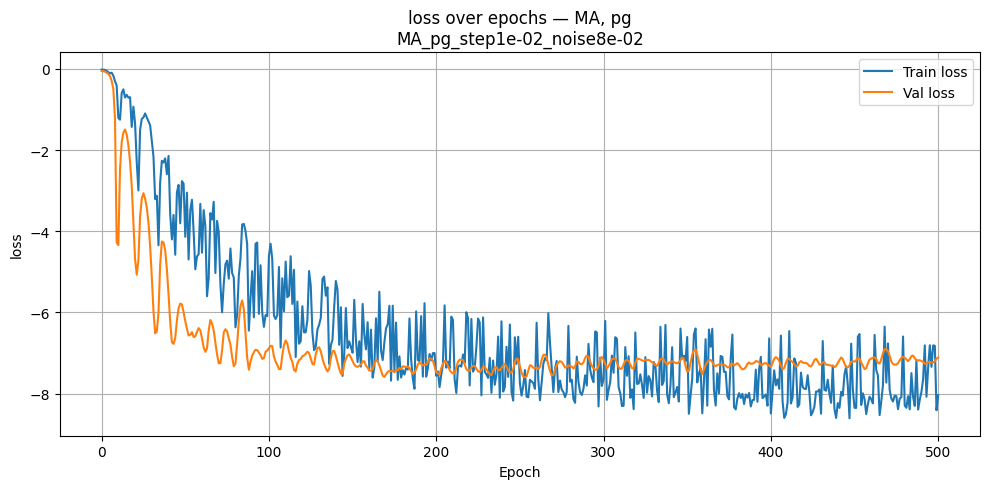

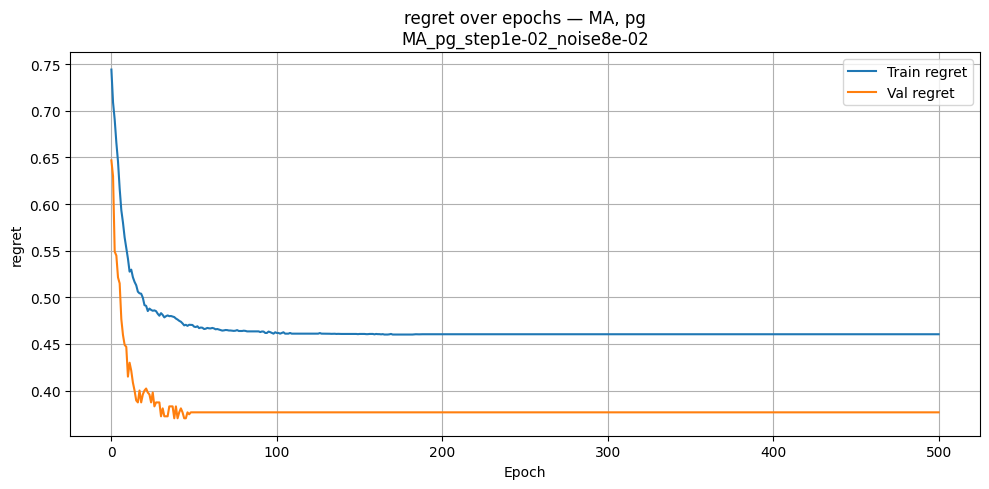

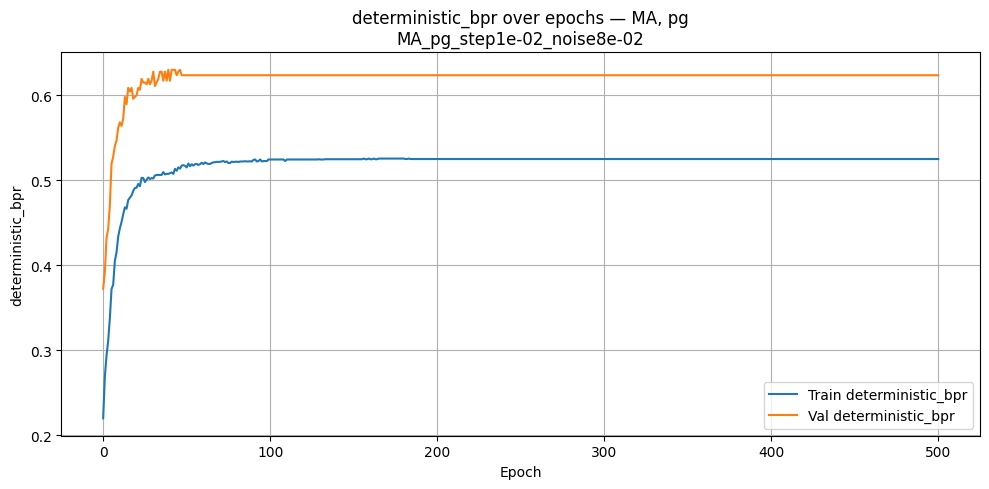

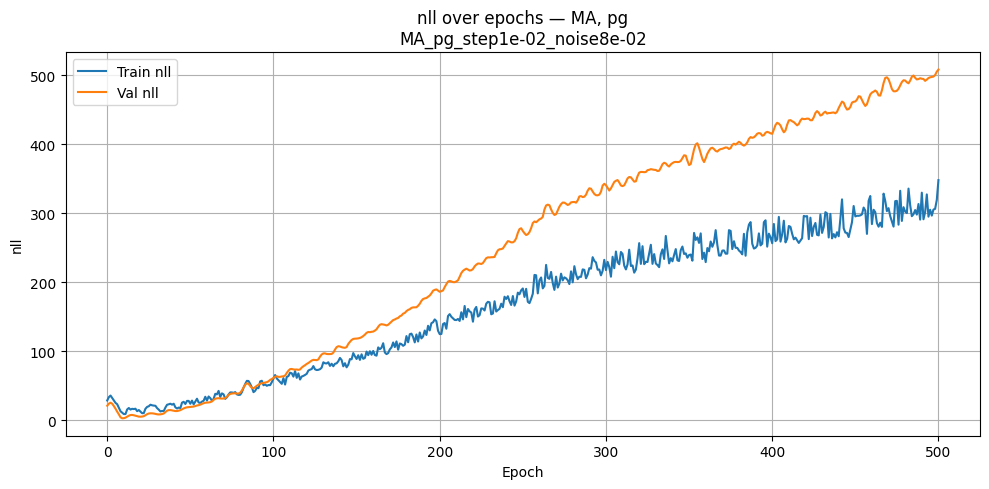

[MA, spo+] → Best final BPR: 0.5723 at /cluster/tufts/hugheslab/kheuto01/pyepo_exps/20250330_run/MA_spo+_step2e-03


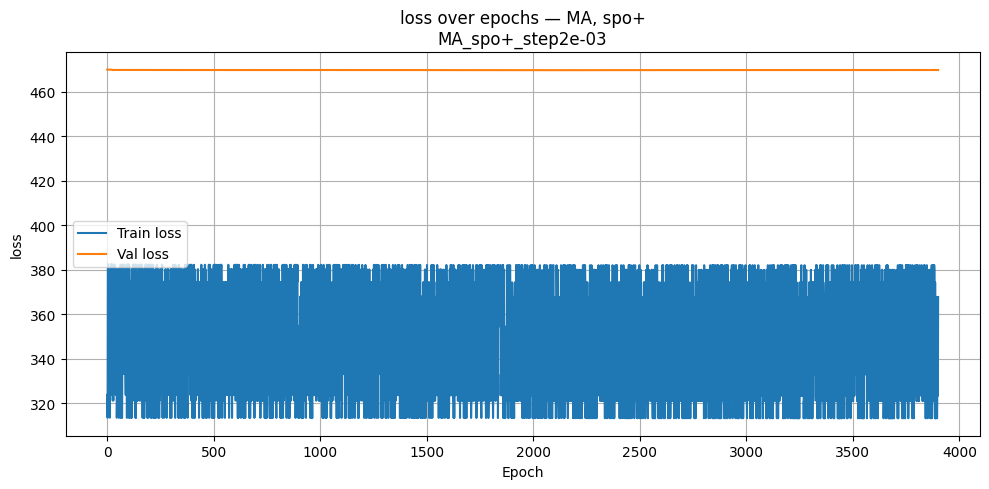

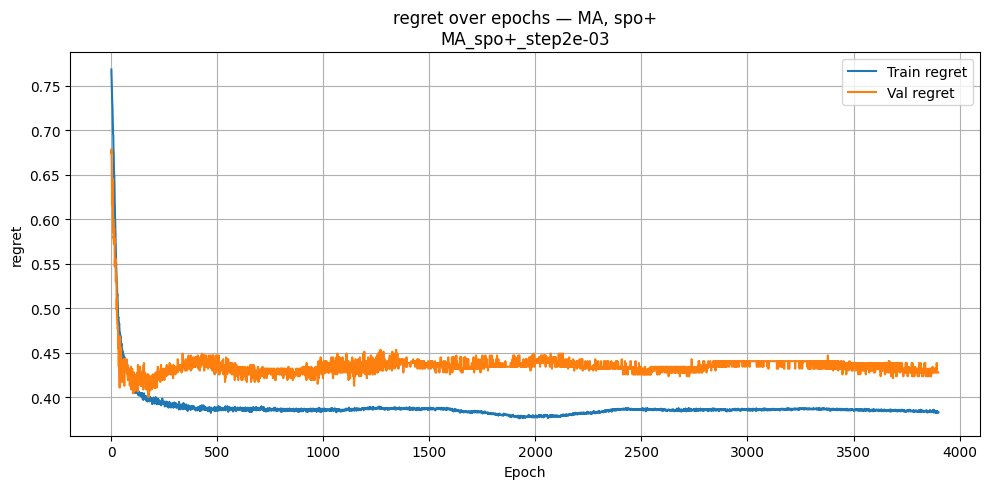

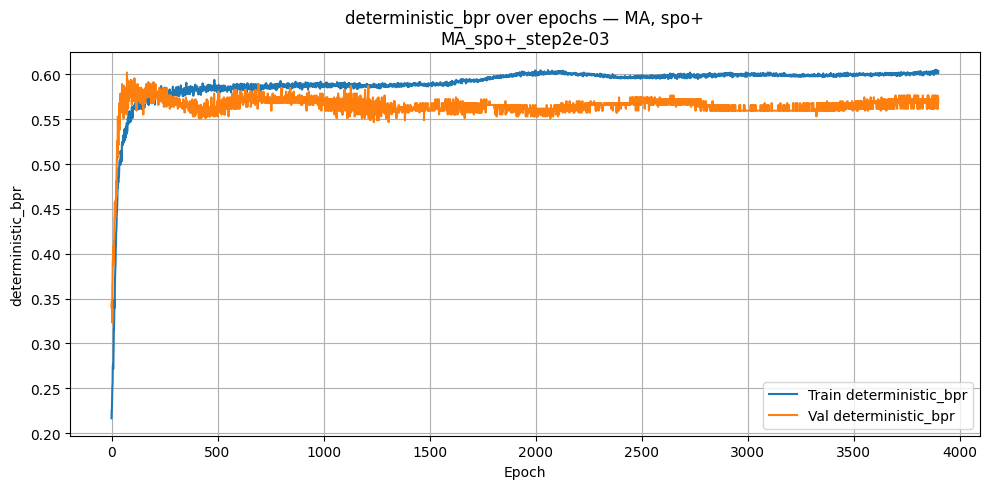

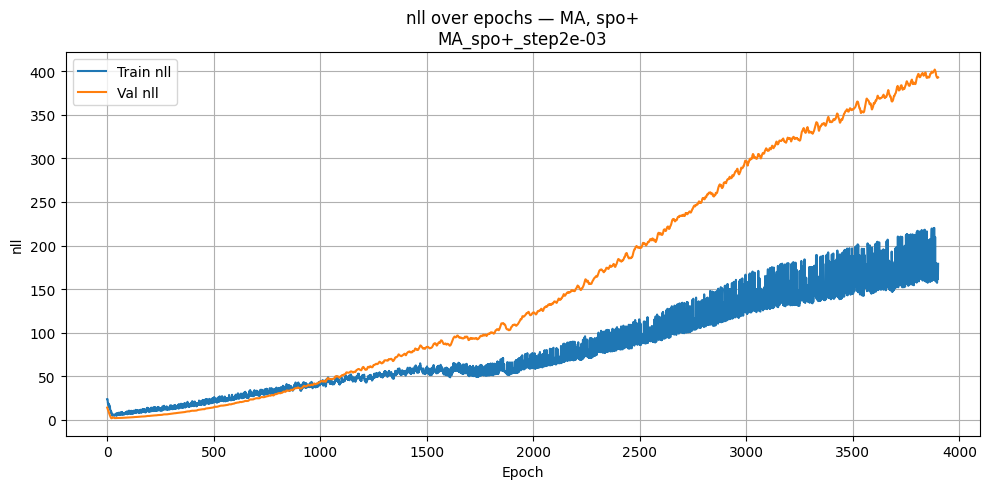

[asurv, pg] → Best final BPR: 0.0000 at /cluster/tufts/hugheslab/kheuto01/pyepo_exps/20250330_run/asurv_pg_step1e-01_noise1e-02


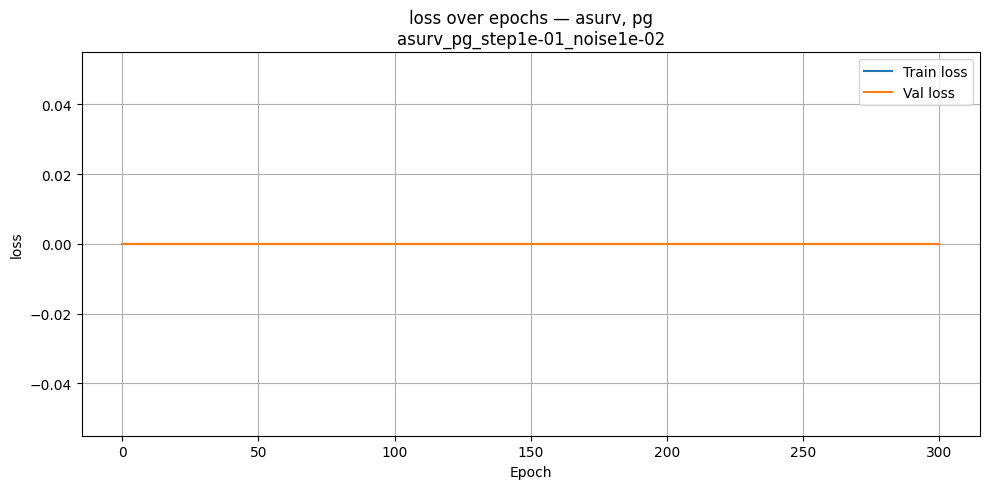

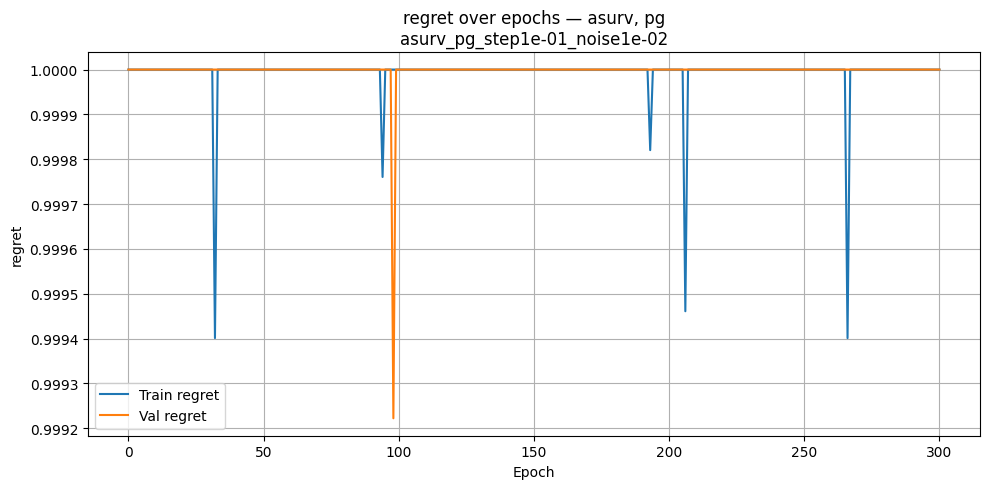

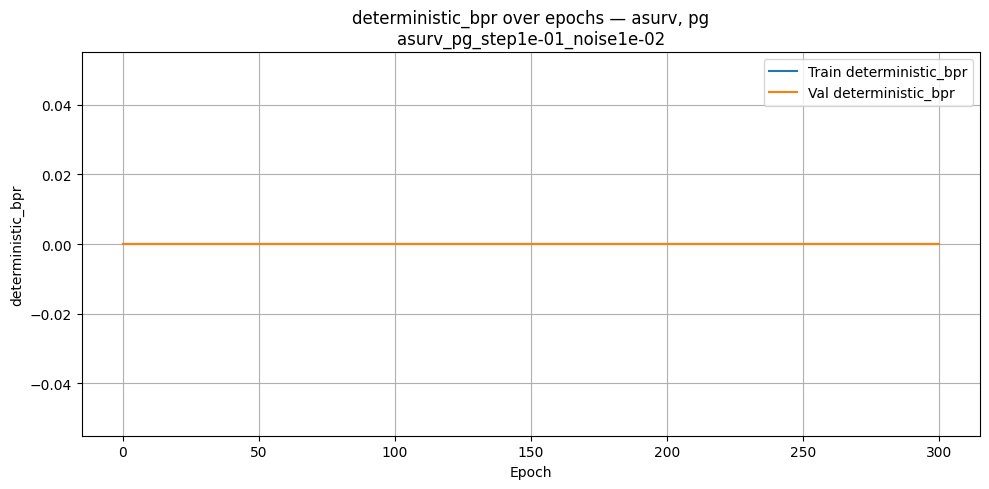

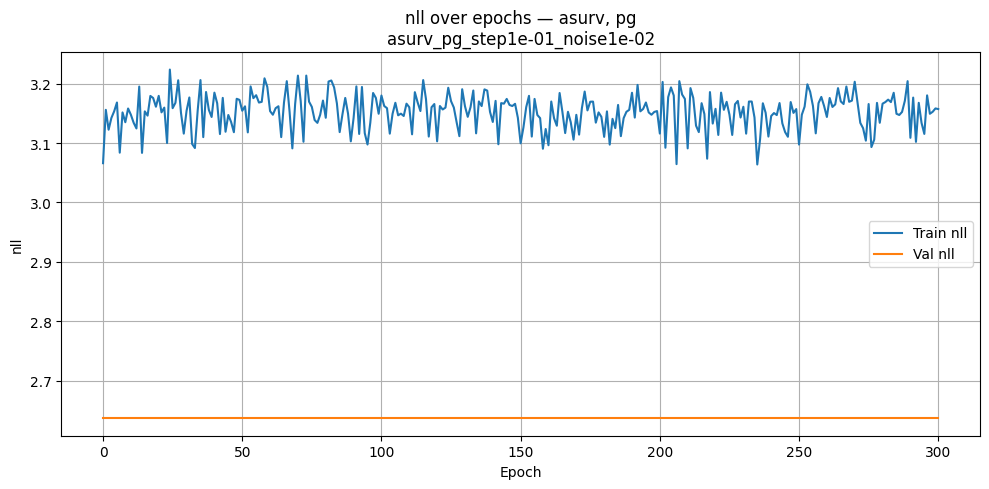

[asurv, spo+] → Best final BPR: 0.0000 at /cluster/tufts/hugheslab/kheuto01/pyepo_exps/20250330_run/asurv_spo+_step1e-01


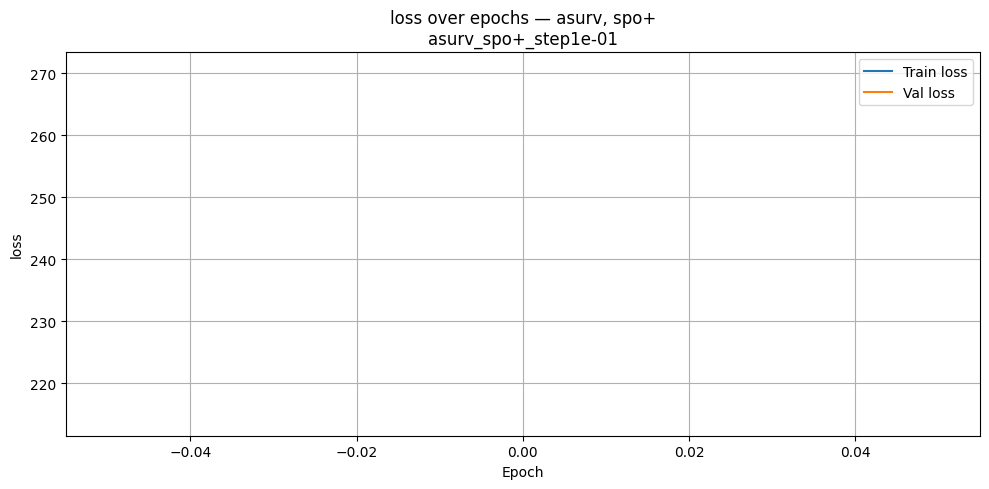

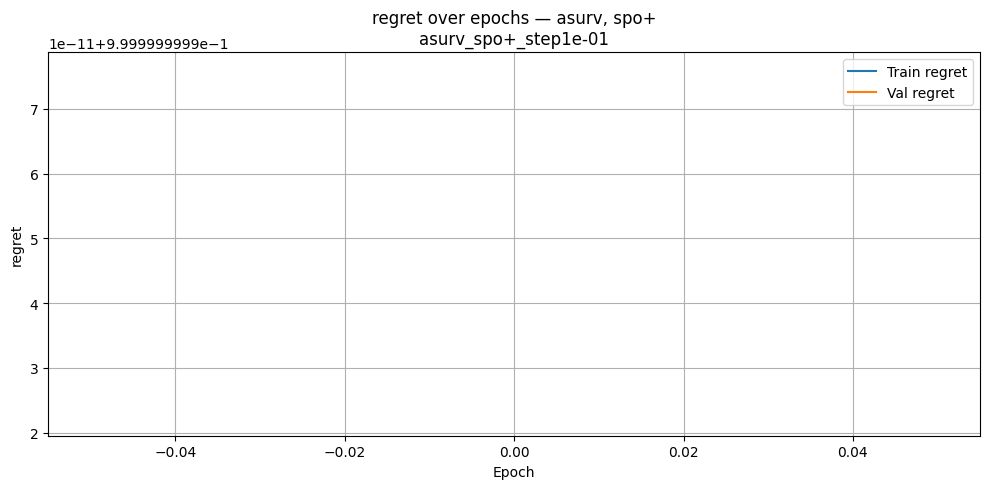

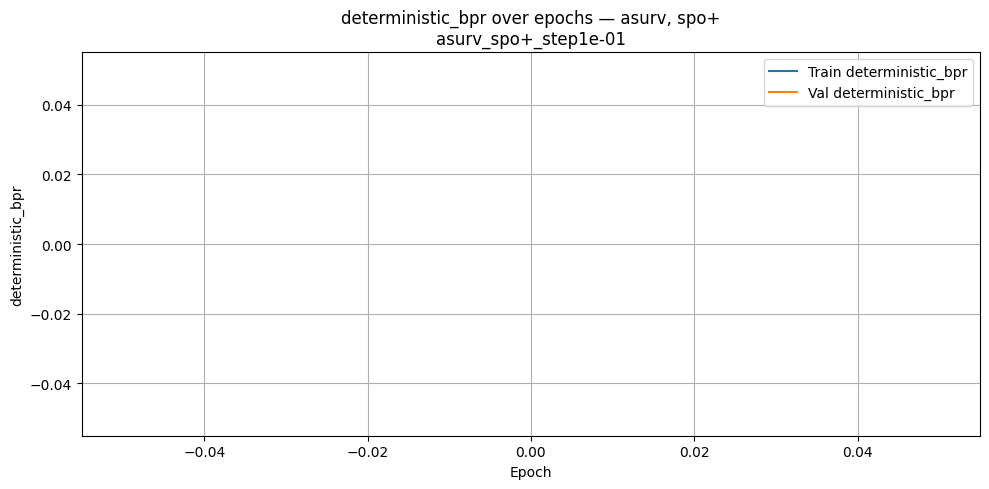

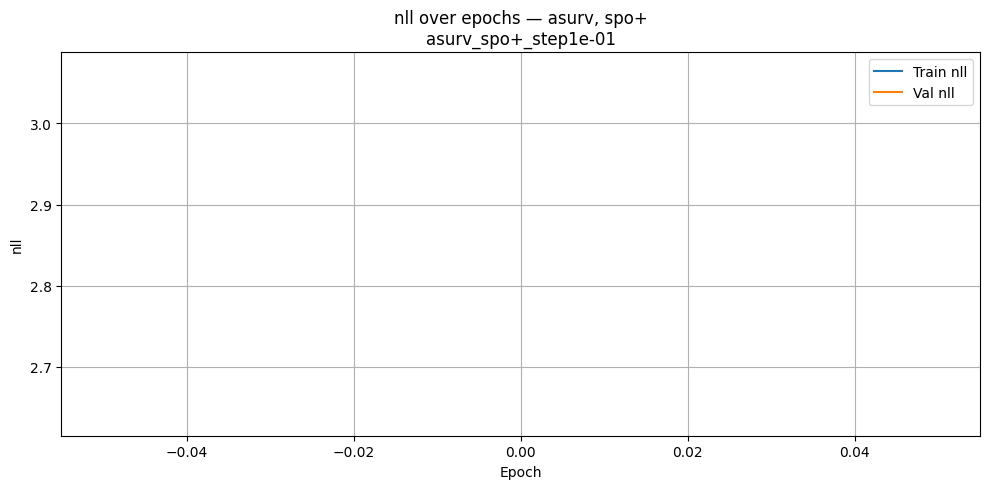

[cook, pg] → Best final BPR: 0.8039 at /cluster/tufts/hugheslab/kheuto01/pyepo_exps/20250330_run/cook_pg_step2e-02_noise1e-02


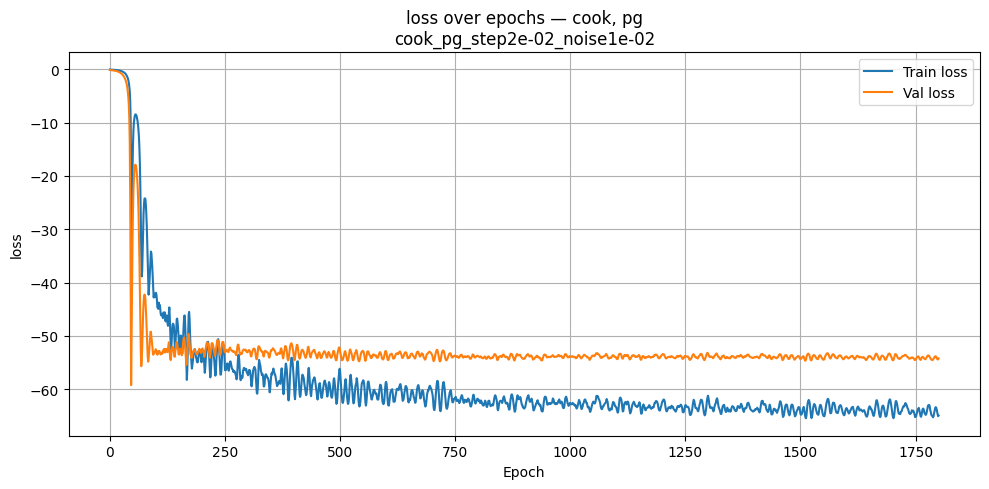

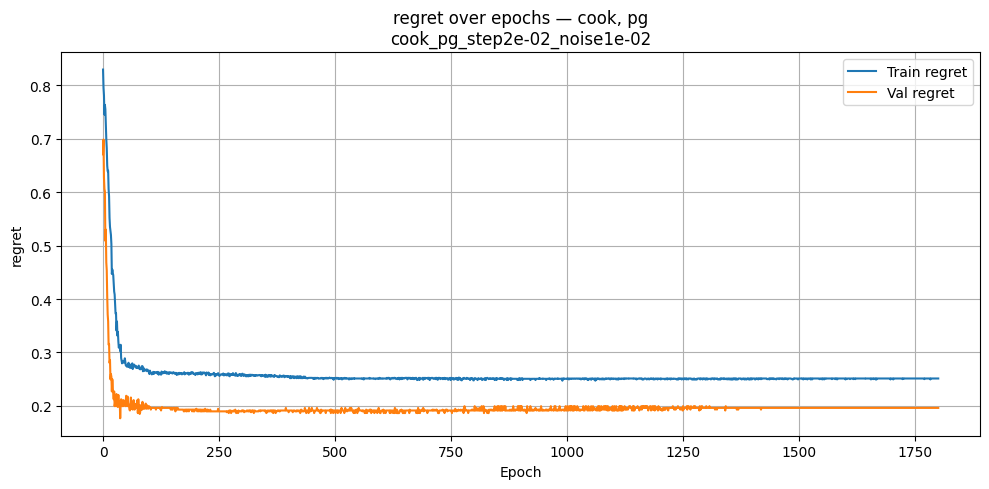

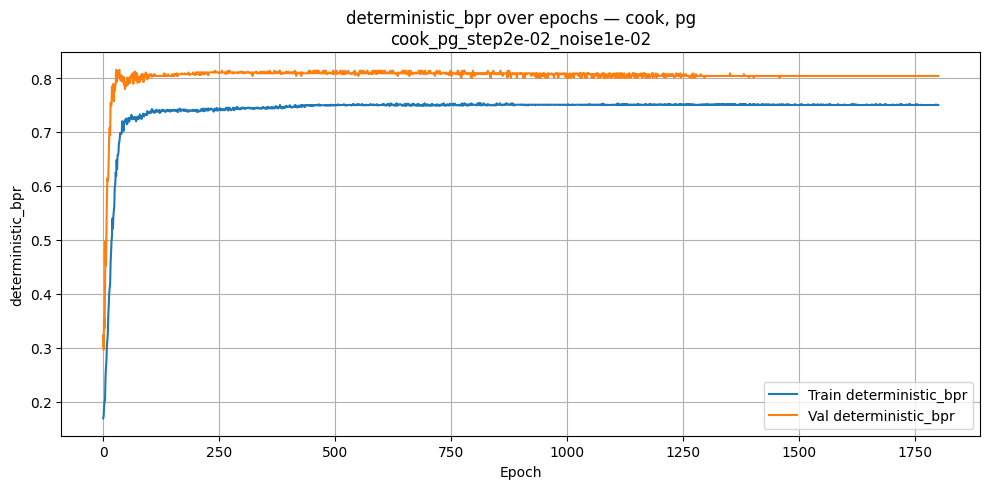

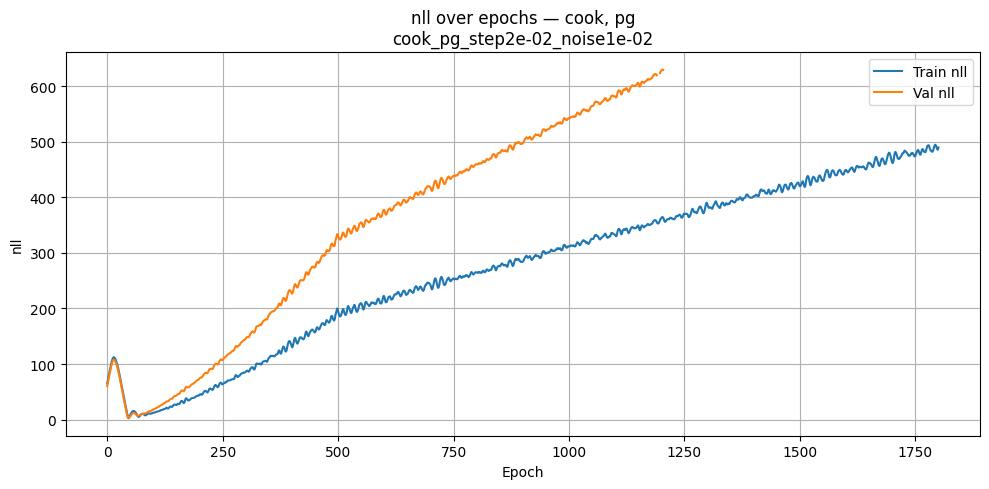

[cook, spo+] → Best final BPR: 0.8039 at /cluster/tufts/hugheslab/kheuto01/pyepo_exps/20250330_run/cook_spo+_step1e-01


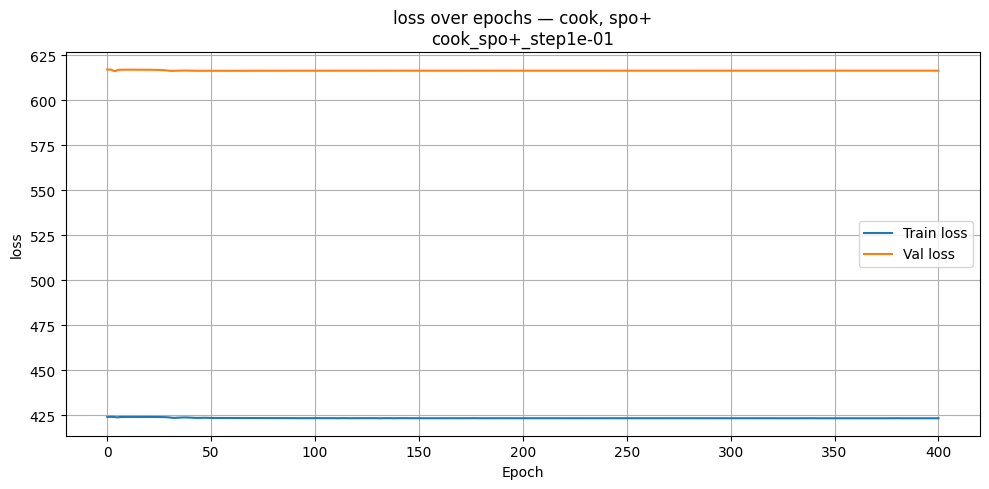

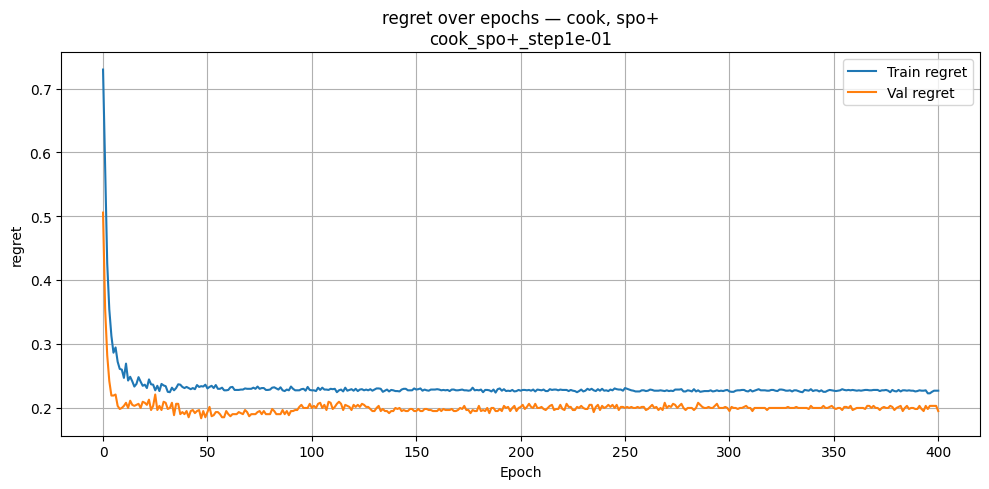

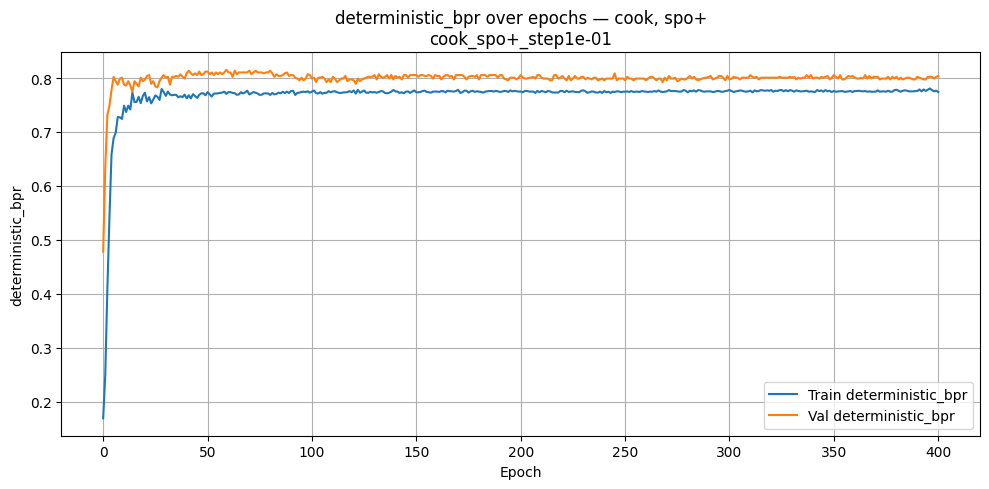

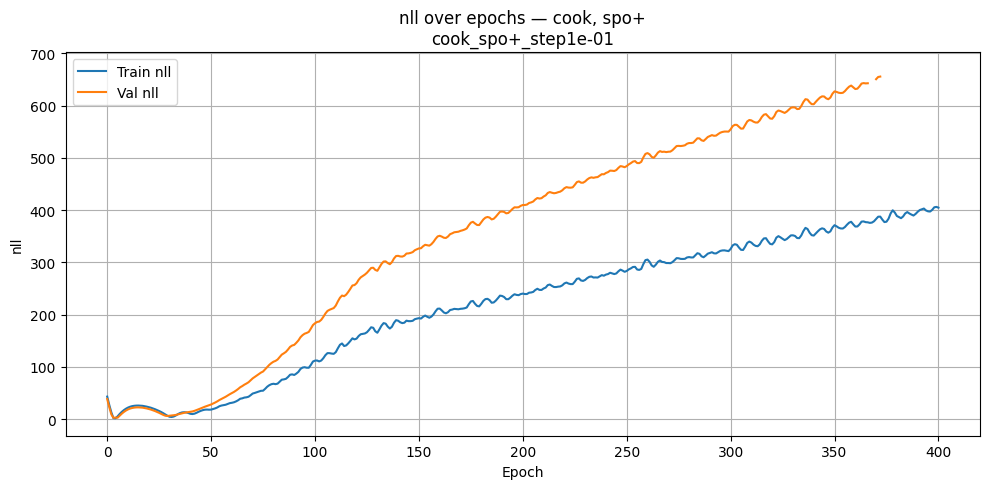

In [7]:
analyze_and_plot_by_final_bpr('/cluster/tufts/hugheslab/kheuto01/pyepo_exps/20250330_run')